In [66]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [67]:
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col ='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

sp500_train.head()

,Close
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893


In [68]:
# Preprocess the data for the Prophet model
sp500_train = sp500_train.reset_index()
sp500_test = sp500_test.reset_index()
sp500_train.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
sp500_test.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)


print(sp500_train.head())
print(sp500_test.head())
tesla_train = tesla_train.reset_index()
tesla_test = tesla_test.reset_index()
tesla_train.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
tesla_test.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

          ds            y
0 2015-01-02  2058.199951
1 2015-01-05  2020.579956
2 2015-01-06  2002.609985
3 2015-01-07  2025.900024
4 2015-01-08  2062.139893
          ds            y
0 2024-01-02  4742.830078
1 2024-01-03  4704.810059
2 2024-01-04  4688.680176
3 2024-01-05  4697.240234
4 2024-01-08  4763.540039


In [87]:
# Modeling with Prophet for S&P 500
model_sp500 = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality= True, changepoint_prior_scale=0.5)
model_sp500.fit(sp500_train)


00:45:21 - cmdstanpy - INFO - Chain [1] start processing
python(92384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
00:45:22 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
# Prediction for the test set
forecast_sp500 = model_sp500.predict(sp500_test)

# Match predictions to actual test dates
forecast_matched = forecast_sp500[forecast_sp500['ds'].isin(sp500_test['ds'])]
comparison_sp500 = pd.merge(sp500_test,forecast_matched[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')


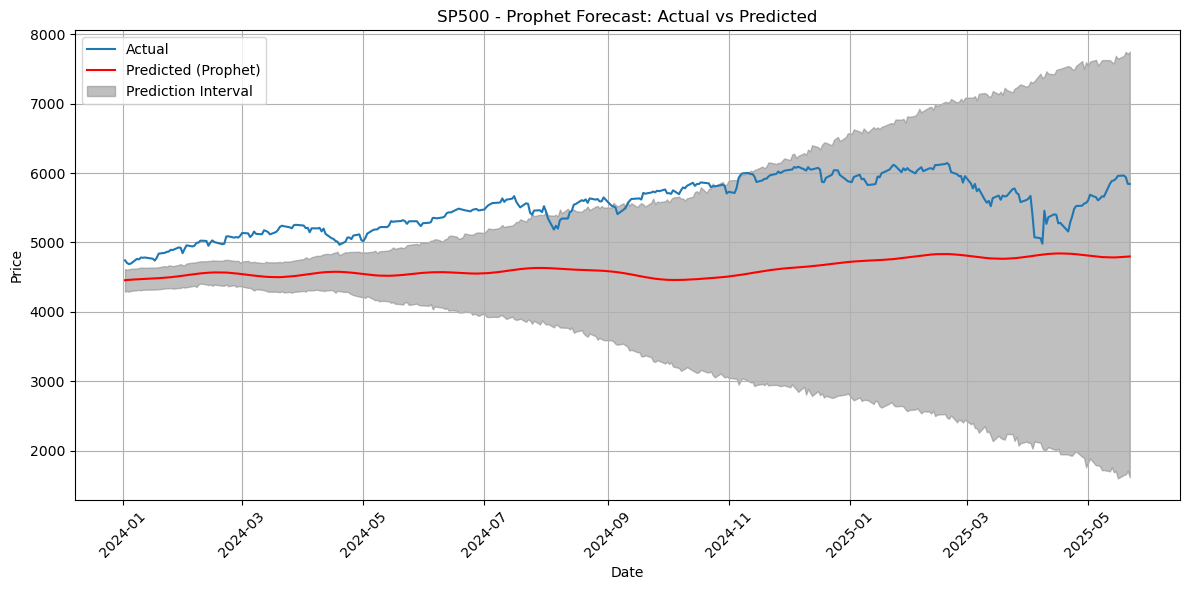

In [89]:
#Plot predictions vs actual values for S&P 500
plt.figure(figsize=(12, 6))
plt.plot(comparison_sp500['ds'], comparison_sp500['y'], label='Actual')
plt.plot(comparison_sp500['ds'], comparison_sp500['yhat'], label='Predicted (Prophet)', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SP500 - Prophet Forecast: Actual vs Predicted')

plt.fill_between(comparison_sp500['ds'], comparison_sp500['yhat_upper'], comparison_sp500['yhat_lower'], color = 'gray', alpha = 0.5, label = 'Prediction Interval')

plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

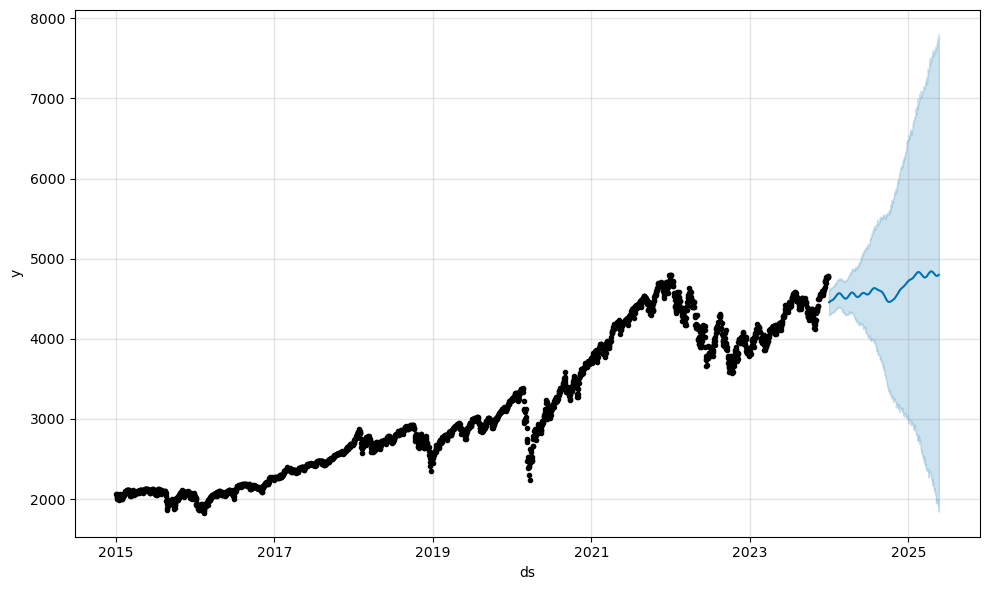

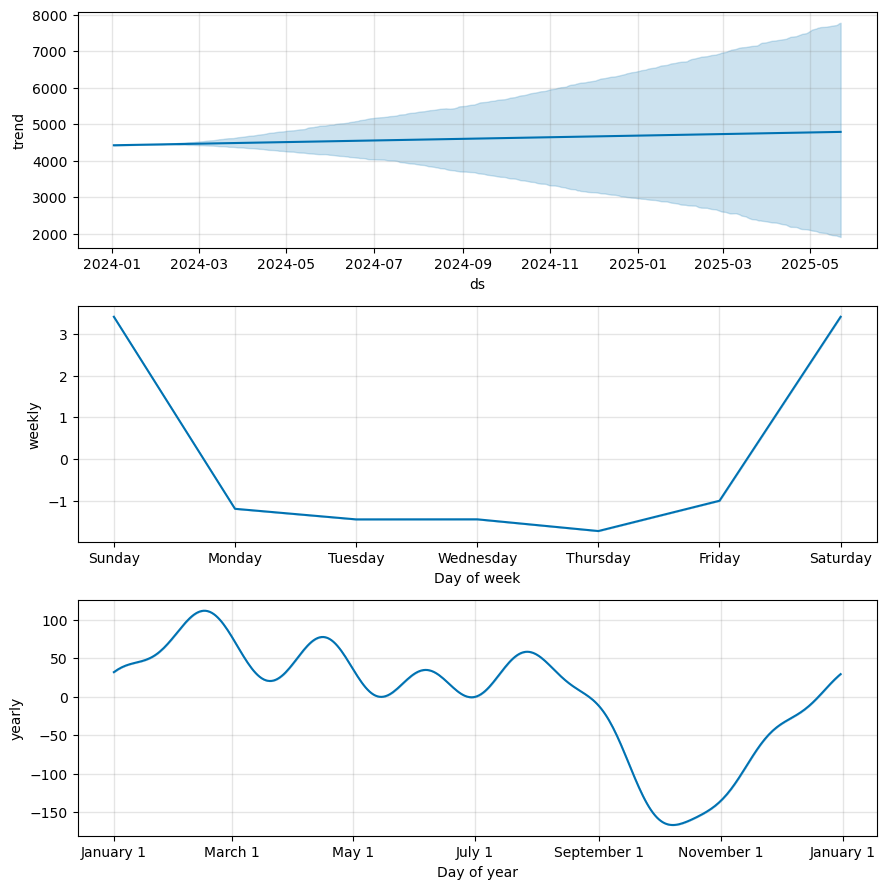

In [72]:
fig = model_sp500.plot(forecast_sp500)
fig2 = model_sp500.plot_components(forecast_sp500)

SP 500 - MAE: 899.5689321839682, MSE: 921761.8401008841, MAPE: 0.15967535235284971


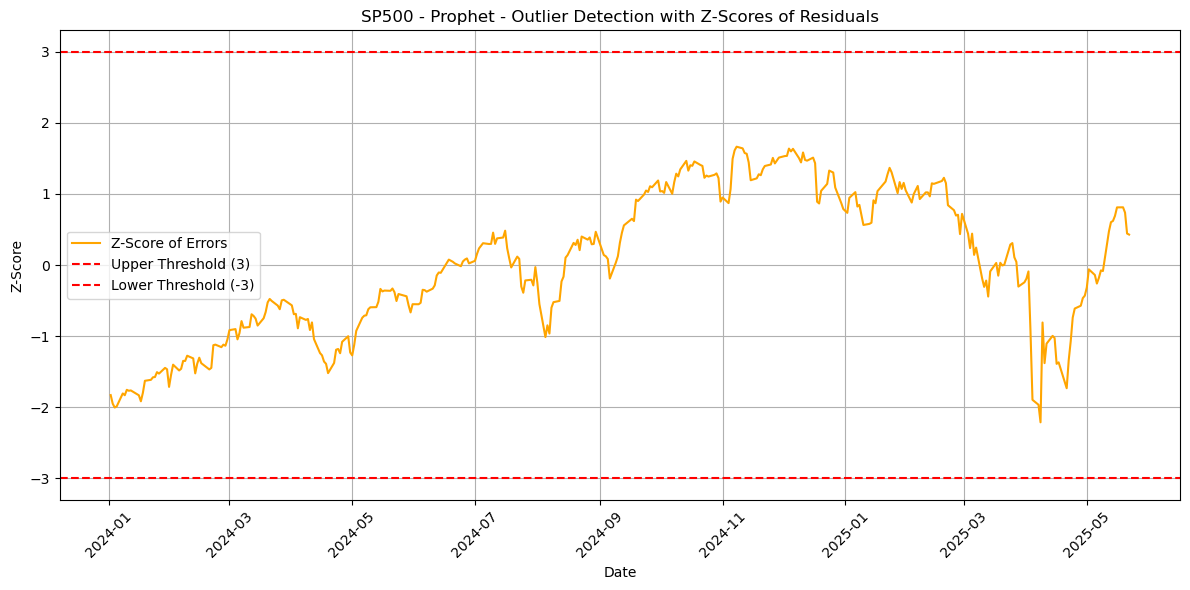

In [73]:
# Calculate the the MAE, MSE, and MAPE for S&P 500
mae_sp500 = mean_absolute_error(comparison_sp500['y'], comparison_sp500['yhat'])
mse_sp500 = mean_squared_error(comparison_sp500['y'], comparison_sp500['yhat'])
mape_sp500 = mean_absolute_percentage_error(comparison_sp500['y'], comparison_sp500['yhat'])

print(f"SP 500 - MAE: {mae_sp500}, MSE: {mse_sp500}, MAPE: {mape_sp500}")

# Calculate the z-scores of the errors
z_score_sp500 = zscore(comparison_sp500['y'] - comparison_sp500['yhat'])

# Plot the z-scores
plt.figure(figsize=(12, 6))
plt.plot(comparison_sp500['ds'], z_score_sp500, label='Z-Score of Errors', color='orange')
plt.axhline(y=3, color='r', linestyle='--', label='Upper Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label = 'Lower Threshold (-3)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('SP500 - Prophet - Outlier Detection with Z-Scores of Residuals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
# Modeling with Prophet for Tesla
model_tesla = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality= True, changepoint_prior_scale=0.3,seasonality_mode='additive')
model_tesla.fit(tesla_train)

21:37:17 - cmdstanpy - INFO - Chain [1] start processing
python(85251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
21:37:18 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
# Predict with model for Tesla
forecast_tesla = model_tesla.predict(tesla_test)

# Match predictions to actual test dates for Tesla
forecast_matched = forecast_tesla[forecast_tesla['ds'].isin(tesla_test['ds'])]
comparison_tesla = pd.merge(
    tesla_test,
    forecast_tesla[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds'
)

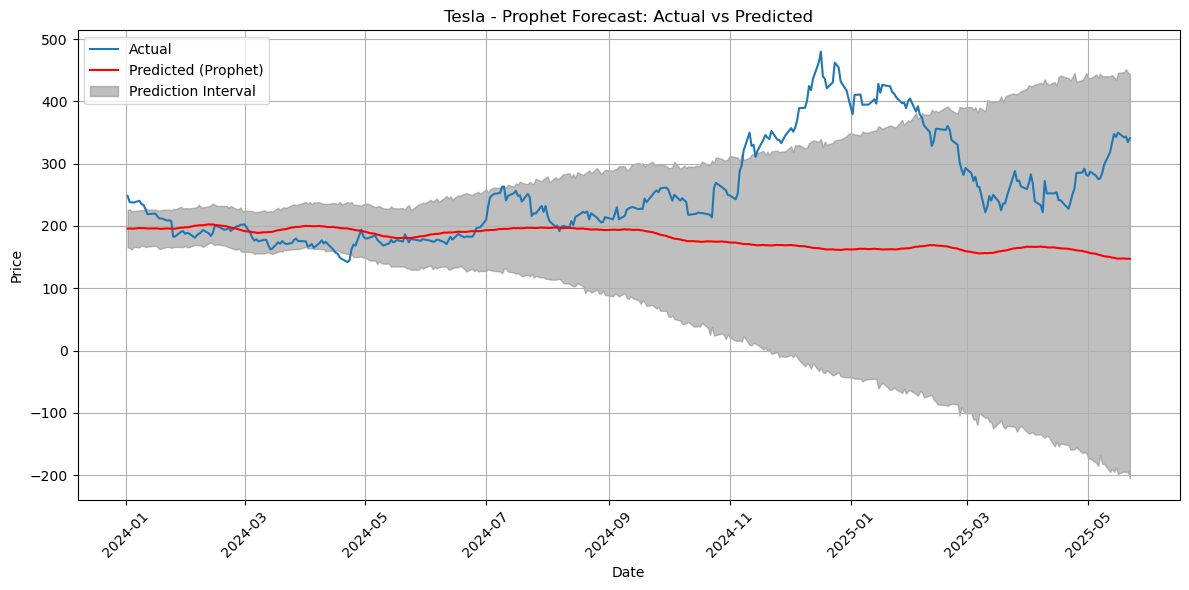

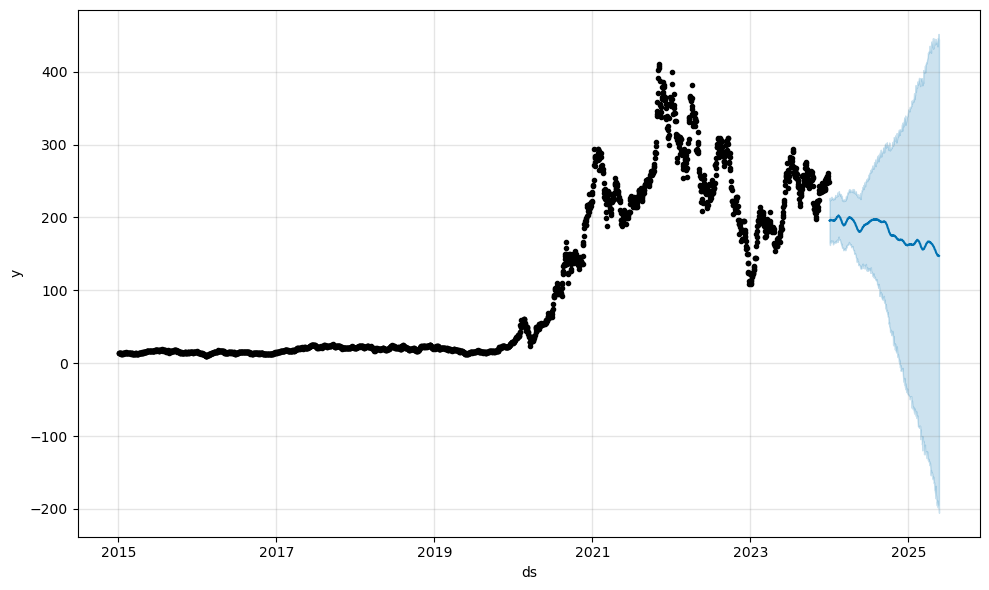

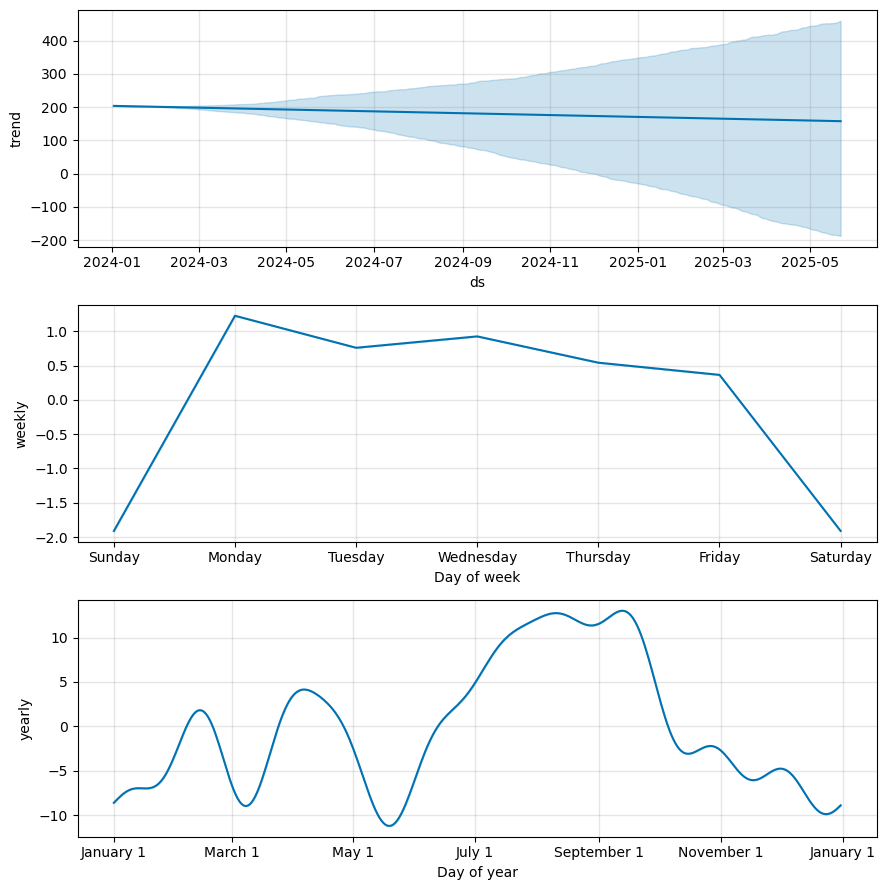

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_tesla['ds'], comparison_tesla['y'], label='Actual')
plt.plot(comparison_tesla['ds'], comparison_tesla['yhat'], label='Predicted (Prophet)', color='r')

plt.fill_between(
    comparison_tesla['ds'],
    comparison_tesla['yhat_lower'],
    comparison_tesla['yhat_upper'],
    color='gray',
    alpha=0.5,
    label='Prediction Interval'
)


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tesla - Prophet Forecast: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

fig3 = model_tesla.plot(forecast_tesla)
fig4 = model_tesla.plot_components(forecast_tesla)

Tesla - MAE: 82.23355214110063, MSE: 13454.799322440587, MAPE: 0.2676732315356074


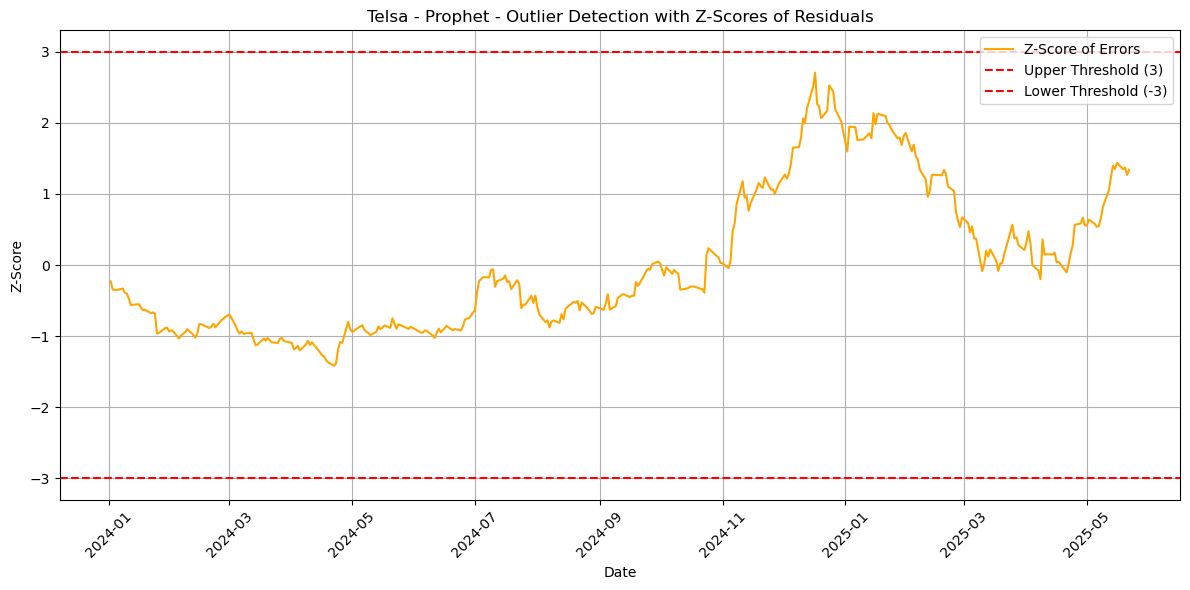

In [77]:
# Calculate the MAE, MSE, and MAPE for Tesla
mae_tesla = mean_absolute_error(comparison_tesla['y'], comparison_tesla['yhat'])
mse_tesla = mean_squared_error(comparison_tesla['y'], comparison_tesla['yhat'])
mape_tesla = mean_absolute_percentage_error(comparison_tesla['y'], comparison_tesla['yhat'])
print(f"Tesla - MAE: {mae_tesla}, MSE: {mse_tesla}, MAPE: {mape_tesla}")

z_score_tesla = zscore(comparison_tesla['y'] - comparison_tesla['yhat'])

plt.figure(figsize=(12, 6))
plt.plot(comparison_tesla['ds'], z_score_tesla, label='Z-Score of Errors', color='orange')
plt.axhline(y=3, color='r', linestyle='--', label='Upper Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Lower Threshold (-3)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Telsa - Prophet - Outlier Detection with Z-Scores of Residuals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

